## Analyzing IMHE projection data

## Business Understanding
Given the massive news coverage there are delays in getting hydroxychloroquine (HCQ) to current patients so I decided to investigate if stockpiling is necessary given the new COVID-19 use case.

1.What will the US hydroxychloroquine needs be? 
2.What is the supply? 
3.What will it cost?

In [1]:
#import necessary libraries
from datetime import datetime,timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot functionality
import sys
import os

## Data Understanding

Gather

In [2]:
# Importing IHME Data (downloaded from http://www.healthdata.org/covid/data-downloads) and converted to only contain US state data
dirname=sys.path[0]
files = [f for f in os.listdir('./') if os.path.isfile(f) and f.endswith('csv')]
for filename in files:
    if "IHME_USA_Proj_Apr08.csv"==filename:
        print(os.path.join(dirname, filename))
        pathname=os.path.join(dirname, filename)
        df_proj=pd.read_csv(filename,parse_dates=['date'],infer_datetime_format=True)


C:\Users\petko\Desktop\Udacity DS\IHME_USA_Proj_Apr08.csv


Assess

In [3]:
df_proj.describe()
df_proj.columns

Index(['Unnamed: 0', 'location_name', 'date', 'deaths_midlower', 'deaths_mean',
       'deaths_lower', 'deaths_upper', 'projected_infections'],
      dtype='object')

## Data Preparation

Clean
Here we are going to clean our dataset. We are going to: 
1.Drop any unwanted columns 
2.Remove <0 i.e. ~1e-11 values caused by floating point import
3.Check if any missing values

In [4]:
#Drop all unnecessary columns
drop_columns=['deaths_midlower','deaths_lower', 'deaths_upper']
df_proj.drop(drop_columns,axis=1, inplace=True)

#Remove values that are clost to 0 but negative
df_proj.min()
df_proj[df_proj.projected_infections<0]=0

#Finding missing values
print(df_proj.isnull().sum())

Unnamed: 0              0
location_name           0
date                    0
deaths_mean             0
projected_infections    0
dtype: int64


## Answer Questions

Analyze

In [5]:
df_grouped=df_proj.groupby('date').agg(['sum'])
df_daily=df_grouped.reset_index()

Model

The model assumes IHME projections of death rate and constant relationship to death rate

In [ ]:
Visualize

1.What will the US hydroxychloroquine needs be? 

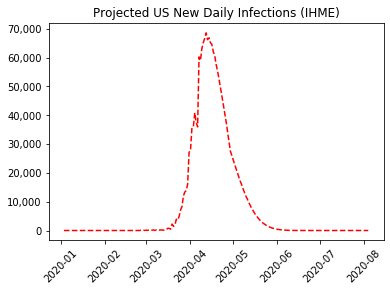

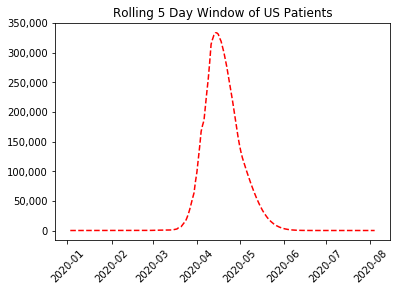

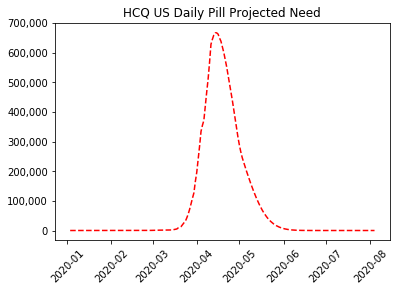

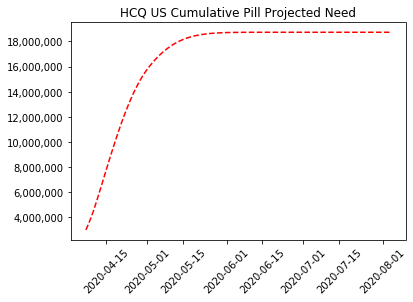

In [6]:
def graph_output(title,x,y):
    '''Plot respective graph with title and x,y coordinates'''
    fig,ax=plt.subplots()
    plt.title(title)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.xticks(rotation=45)
    plt.plot(x, y,'r--',)

# Plot US Day by Day Projected Infections IHME
graph_output('Projected US New Daily Infections (IHME)',df_daily.date,df_daily.projected_infections)

# Create 5 Day Treatment Window using 400mg per day
df_proj['5day_infected_HQregimen_patients']=df_proj.projected_infections.rolling(5,min_periods=1).agg(['sum'])
dfAggByDate=df_proj.groupby("date")['5day_infected_HQregimen_patients'].agg('sum')
dfwithHQPills=pd.DataFrame({'cases':dfAggByDate,'HQ_Pills':dfAggByDate.values*2})

# Assuming 5-day treatment plan how many patients would be subject to a HCQ regimen if prescribed to all patients
graph_output('Rolling 5 Day Window of US Patients',dfAggByDate.index,dfwithHQPills.cases)

# Plot Hydroxychloroquine Daily Usage if prescribed to all patients and assuming medium level projected IHME infection curve
graph_output('HCQ US Daily Pill Projected Need',dfAggByDate.index,dfwithHQPills.HQ_Pills)

# Plot Total Number of Pills Needed
cumulative_pills=dfwithHQPills.HQ_Pills.cumsum().tail(120)
graph_output('HCQ US Cumulative Pill Projected Need',dfAggByDate.tail(120).index,cumulative_pills.values)

# Cumulative Pills Needed
total_pills=dfwithHQPills.HQ_Pills.cumsum().tail(1)

Evaluate

2.What is the supply? 

In [ ]:
#Found from a variety of external sources it is >40M
#Teva shipped 6M by Mar 31 and plans additional 10M by end of April
#Sandoz (Novartis) 30M shipping from Mar.30
#Mylan has started production in W.Virginia and is planning imports from overseas
#Bayer 3M tablets of chloroquine phosphate. That is not HCQ but can be potentially used as a substitute after additional FDA approval

3.What will it cost?

In [7]:
# Cost Calc. *ignoring donations* and assume 4x developing world cost
total_price=.04*4*total_pills